# Volatility Measures Comparison

Compute and compare multiple volatility measures for Bitcoin.


In [1]:
import pandas as pd
import numpy as np
from pathlib import Path

project_root = Path('..')

# Load prices
prices_csv = project_root / 'data' / 'raw' / 'bitcoin_prices.csv'
with open(prices_csv, 'r', encoding='utf-8') as f:
    line1 = f.readline().strip(); f.readline(); f.readline()
columns = ['Date'] + [h.strip().strip('"') for h in line1.split(',')]
prices = pd.read_csv(prices_csv, skiprows=3, header=None, names=columns)
prices['Date'] = pd.to_datetime(prices['Date'], errors='coerce')
prices = prices.dropna(subset=['Date']).set_index('Date').sort_index()

for c in prices.columns:
    if c != 'Ticker' and prices[c].dtype == 'object':
        prices[c] = pd.to_numeric(prices[c], errors='coerce')

# Choose base price series
price_col = 'Close' if 'Close' in prices.columns else ('Price' if 'Price' in prices.columns else None)
if price_col is None:
    raise ValueError("Neither 'Close' nor 'Price' column found in prices.")

prices['ret'] = prices[price_col].pct_change()

# Volatility measures
window = 30
vol_std = prices['ret'].rolling(window).std() * np.sqrt(365)
vol_parkinson = (1/(4*np.log(2))) * ((np.log(prices['High']/prices['Low']))**2).rolling(window).mean() * np.sqrt(365)

# Garman-Klass
vol_gk = (0.5*(np.log(prices['High']/prices['Low'])**2) - (2*np.log(2)-1)*(np.log(prices[price_col]/prices[price_col].shift())**2)).rolling(window).mean()*np.sqrt(365)

vol_df = pd.DataFrame({
    'vol_std_30d_ann': vol_std,
    'vol_parkinson_30d_ann': np.sqrt(vol_parkinson),
    'vol_gk_30d_ann': np.sqrt(vol_gk)
})
vol_df.tail()


/Users/vepusanannanthakumar/Desktop/final-research-project-statify/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


,vol_std_30d_ann,vol_parkinson_30d_ann,vol_gk_30d_ann
Date,,,
2024-12-26,0.423008,0.078547,0.071023
2024-12-27,0.425357,0.079473,0.072296
2024-12-28,0.429450,0.079216,0.071419
2024-12-29,0.422639,0.080064,0.073431
2024-12-30,0.420803,0.080614,0.074492


Text(0, 0.5, 'Annualized Volatility')

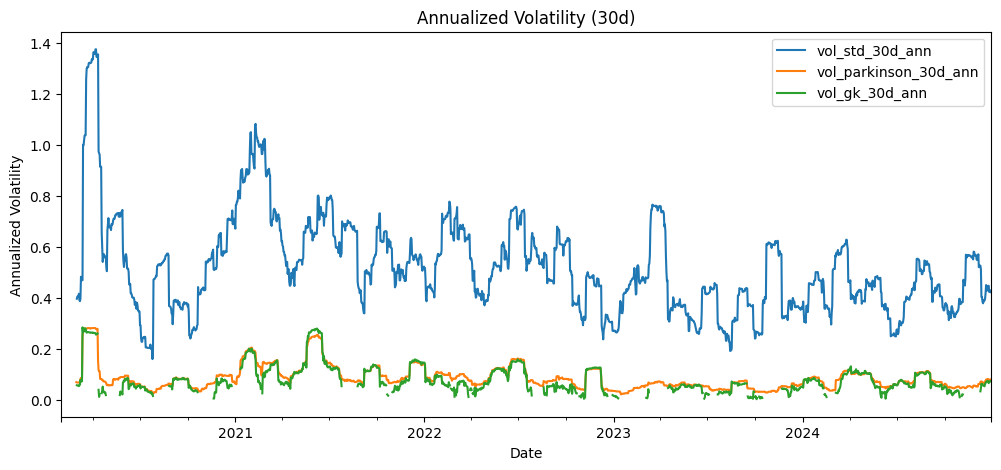

In [2]:
# Plot volatility measures
ax = vol_df[['vol_std_30d_ann','vol_parkinson_30d_ann','vol_gk_30d_ann']].plot(figsize=(12,5), title='Annualized Volatility (30d)')
ax.set_ylabel('Annualized Volatility')
